# Generative Models 1

Ontological modeling — formalizing a hypothesis of the data-generating
process

## Models, simulation, and degrees of belief

One view of knowledge is that the mind maintains working models of parts
of the world. ‘Model’ in the sense that it captures some of the
structure in the world, but not all (and what it captures need not be
exactly what is in the world—just what is useful). ‘Working’ in the
sense that it can be used to simulate this part of the world, imagining
what will follow from different initial conditions. As an example take
the Plinko machine: a box with uniformly spaced pegs, with bins at the
bottom. Into this box we can drop marbles:

The plinko machine is a ‘working model’ for many physical processes in
which many small perturbations accumulate—for instance a leaf falling
from a tree. It is an approximation to these systems because we use a
discrete grid (the pegs) and discrete bins. Yet it is useful as a model:
for instance, we can ask where we expect a marble to end up depending on
where we drop it in, by running the machine several times—simulating the
outcome.

Imagine that someone has dropped a marble into the plinko machine;
before looking at the outcome, you can probably report how much you
believe that the ball has landed in each possible bin. Indeed, if you
run the plinko machine many times, you will see a shape emerge in the
bins. The number of balls in a bin gives you some idea of how much you
should expect a new marble to end up there. This ‘shape of expected
outcomes’ can be formalized as a probability distribution (described
below). Indeed, there is an intimate connection between simulation,
expectation or belief, and probability, which we explore in the rest of
this section.

There is one more thing to note about our Plinko machine above: we are
using a computer program to simulate the simulation. Computers can be
seen as universal simulators. How can we, clearly and precisely,
describe the simulation we want a computer to do?

## Building Generative Models

We wish to describe in formal terms how to generate states of the world.
That is, we wish to describe the causal process, or steps that unfold,
leading to some potentially observable states. The key idea of this
section is that these generative processes can be described as
*computations*—computations that involve random choices to capture
uncertainty about the process.

Programming languages are formal systems for describing what
(deterministic) computation a computer should do. Modern programming
languages offer a wide variety of different ways to describe
computation; each makes some processes simple to describe and others
more complex. However, a key tenet of computer science is that all of
these languages have the same fundamental power: any computation that
can be described with one programming language can be described by
another. (More technically this [Church-Turing
thesis](https://en.wikipedia.org/wiki/Church%E2%80%93Turing_thesis)
posits that many specific computational systems capture the set of all
effectively computable procedures. These are called universal systems.)

------------------------------------------------------------------------

## Two approaches to generative modeling

Consider how we might simulate a coin being flipped, as random samples
from a Bernoulli distribution.

In [15]:
from scipy.stats import bernoulli
from numpy.random import seed

ACoin = bernoulli(0.5)

If you run `ACoin.rvs()` multiple times you’ll see that you get `0`
($\text{TAILS}$) sometimes and `1` ($\text{HEADS}$) sometimes.

In [16]:
ACoin.rvs()

1

But what’s happening under the hood? It becomes clearer when we set a
random seed:

In [17]:
seed(100)
ACoin.rvs()
### uncomment to take multiple samples ###
ACoin.rvs()
ACoin.rvs()

0

When you run this cell multiple times what do you see? There is no more
randomness. Our simulated coin always comes up $\text{HEADS}$.

Of course, this only happens because we set the random seed to the same
value right before drawing each sample. If we were to sample `ACoin`
multiple times without resetting the seed, we would draw different
values, and in the limit of infinite samples, the proportion of
$\text{TAILS}$ and $\text{HEADS}$ would be equal.

This trivial example illustrates a property of probability. There is
nothing random about probability distributions. When we write
`bernoulli(0.5)` we’re assigning probability mass to subsets of the
outcomes $\{\text{TAILS}, \text{HEADS}\}$. When we draw a sample by
calling `.rvs()`, a (pseudo)random number is passed to a deterministic
function that maps the state space of the random number generator to
subsets of the outcomes.

In other words, one way of building generative models involves drawing
samples according to specified distributions and collecting the results.
For instance, let’s simulate 1000 flips of two fair coins and calculate
how often they both come up $\text{HEADS}$:

In [18]:
seed(100)
FairCoin1 = bernoulli(0.5)
FairCoin2 = bernoulli(0.5)
n = 1000
both_heads = 0
for i in range(n):
    if FairCoin1.rvs() == 1 and FairCoin2.rvs() == 1:
        both_heads += 1

print(f"The coins both came up HEADS in {both_heads/n:0.3} proportion of the trials")

The coins both came up HEADS in 0.234 proportion of the trials


But it also often possible and preferable to calculate probabilities of
interest directly. This is the approach taken by `memo`.

`memo` enables blisteringly fast generative modeling by compiling
probabilistic models down to [JAX](https://jax.readthedocs.io/) *array
programs* (Chandra et al. 2025).

Let’s explore how `memo` flips coins.

We’ll start by defining the [sample
space](https://en.wikipedia.org/wiki/Sample_space) of a coin:
$S = \{ T, H \}$ (where $T$ and $H$ are $\text{TAILS}$ and
$\text{HEADS}$, which are represented by $0$ and $1$, respectively).

In [19]:
import jax
import jax.numpy as jnp

Coin1 = jnp.array(
    [
        0,  # TAILS,
        1,  # HEADS
    ]
)

JAX is a pretty amazing feat of engineering that sets a gold standard
for efficiency. While widely used, it is still under active development,
and at present, the focus on speed has involved compromises on safety
and flexibility. For instance, notice that while we can index the JAX
array we defined similar to a `numpy` array,

In [20]:
Coin1[0]
# Coin1[1]

Array(0, dtype=int32)

but unlike `numpy`, JAX does not prevent us from doing things that we
should not be able to do, like indexing outside of the array:

In [21]:
Coin1[2]
Coin1[100]

Array(1, dtype=int32)

So when using JAX, it’s especially important to examine, probe and
verify your code thoroughly. Incorrect indexing into multidimensional
arrays are a common mistake, and JAX has few builtin protections. For
more information, you can read about [JAX’s sharp
bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html).

> **JAX - The Sharp Bits**
>
> Information about some of the [Common “Gotchas” in
> JAX](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html)

### Enumeration

Now let’s write a `memo` model that enumerates over the sample space of
the coin.

In [22]:
from memo import memo

Coin1 = jnp.array([0, 1])

@memo
def f[_c: Coin1]():
    return _c



Array([0, 1], dtype=int32)

We defined `f()` to return the outcome `_c` in `Coin1`, so calling `f()`
returns an array of every realization that `_c` can take. We can get a
nice tabular printout using the `print_table` keyword when we call the
model.

In [23]:
f(print_table=True)

+-----------+--------+
| _c: Coin1 | f[_c]  |
+-----------+--------+
| 0         | 0      |
| 1         | 1      |
+-----------+--------+


Array([0, 1], dtype=int32)

JAX arrays are necessarily numeric, but it would be nice if we could
define that $\text{TAILS} ::= 0$ and $\text{HEADS} ::= 1$ for the model.
We can do that using `IntEnum` from the standard package `enum`.

In [24]:
from enum import IntEnum

class Coin(IntEnum):
    TAILS = 0
    HEADS = 1

@memo
def f_enum[_c: Coin]():
    return _c

res = f_enum(print_table=True)

+----------+-------------+
| _c: Coin | f_enum[_c]  |
+----------+-------------+
| TAILS    | 0           |
| HEADS    | 1           |
+----------+-------------+


### Enumeration with probability proportional to (`wpp`)

Let’s now have `memo` flip the coin. We do this using `given` (or
`chooses`, but we’ll get to that later) by specifying the probability
mass on each outcome. `wpp` stands for “with probability proportional
to” and setting it to 1 means a uniform distribution over
${\_}{c} \in \text{Coin}$.

A key design principle of `memo` is **encapsulation**, meaning that
information is bound to “**frames**” and is not automatically accessible
from outside the frame. We’ll see how important this architecture is
when we start modeling minds’ mental models of other minds’ mental
models. For now, we’ll define an `observer` frame that represents the
outcome `c` of the `Coin` flip. This information is bound to the
observer’s mind, so we always need to access it within the observer
frame (e.g. with `observer.c`).

Finally, we enumerate over ${\_}{c} \in Coin$ and return the probability
(`Pr[]`) that `_c` was the outcome of the coin toss.

In [25]:
@memo
def g[_c: Coin]():
    observer: given(c in Coin, wpp=1)
    return Pr[observer.c == _c]

res = g(print_table=True)

+----------+--------+
| _c: Coin | g[_c]  |
+----------+--------+
| TAILS    | 0.5    |
| HEADS    | 0.5    |
+----------+--------+


> **bound and unbound information**
>
> I find it useful to clearly differentiate variables bound to frames
> (e.g. `c` in `observer: given(c in Coin, ...`) from unbound variables
> (e.g. `_c` in `[_c: Coin]`).
>
> This is not strictly necessary, `memo` keeps these separate
> internally, such that one could also write
>
> ``` python
> @memo
> def g[c: Coin]():
>     observer: given(c in Coin, wpp=1)
>     return Pr[observer.c == c]
> ```
>
> in which case the `c` in `observer: given(c in Coin, ...)` refers the
> bound `c` whereas the `c` in `Pr[... == c]` refers to the unbound `c`.
>
> In this course, I will typically use a convention of denoting unbound
> variables with a leading underscore.

### Assigning probability mass

Of course, not all distributions are uniform. We use `wpp` to specify
the probability mass of outcomes.

E.g., to model a biased coin, we can specify that there’s greater
probability mass on $\text{TAILS}$ than on $\text{HEADS}$.

One way to do this is with a ternary.[1] Rather than `wpp=1`, we can
write

[1] Ternary conditionals in Python take the form

``` python
value_if_true if condition else value_if_false
```

E.g.,

``` python
even = True if x % 2 == 0 else False
```

*Ternary* means “composed of three parts” (from the Latin *ternarius*).

In [26]:
@memo
def f_ternary[_c: Coin]():
    observer: given(c in Coin, wpp=0.8 if c == 0 else 0.2)
    return Pr[observer.c == _c]

res = f_ternary(print_table=True)

+----------+----------------------+
| _c: Coin | f_ternary[_c]        |
+----------+----------------------+
| TAILS    | 0.800000011920929    |
| HEADS    | 0.20000000298023224  |
+----------+----------------------+


Alternatively, we can define a custom probability mass function as a
`@jax.jit` that we pass as `wpp`.

In [27]:
@jax.jit
def biased_coin_pmf(c):
    return jnp.array([0.8, 0.2])[c]

@memo
def f_jit[_c: Coin]():
    observer: given(c in Coin, wpp=biased_coin_pmf(c))
    return Pr[observer.c == _c]

res = f_jit(print_table=True)

+----------+----------------------+
| _c: Coin | f_jit[_c]            |
+----------+----------------------+
| TAILS    | 0.800000011920929    |
| HEADS    | 0.20000000298023224  |
+----------+----------------------+


*Note* that `wpp` normalizes the values passed to it (which is why
`wpp=1` forms a uniform distribution):

In [28]:
@jax.jit
def biased_coin_improper_pmf(c):
    return jnp.array([16, 4])[c]  ### NB the improper probability masses

@memo
def f_jit_autonorm[_c: Coin]():
    observer: given(c in Coin, wpp=biased_coin_improper_pmf(c))
    return Pr[observer.c == _c]

res = f_jit_autonorm(print_table=True)

+----------+----------------------+
| _c: Coin | f_jit_autonorm[_c]   |
+----------+----------------------+
| TAILS    | 0.800000011920929    |
| HEADS    | 0.20000000298023224  |
+----------+----------------------+


### Output options

`memo` can package the results in a variety of ways. By default, a
`@memo` returns a JAX array.

In [29]:
f_jit()

Array([0.8, 0.2], dtype=float32)

It is possible to additionally have `@memo` package the data in a 2D
[`pandas`](https://pandas.pydata.org/docs/)
[DataFrame](https://pandas.pydata.org/docs/reference/frame.html)

In [30]:
df = f_jit(return_pandas=True).aux.pandas
print("DataFrame:")
print(df)
print("\nsliced:")
print(df.loc[df["_c"] == "HEADS"])

DataFrame:
      _c  f_jit
0  TAILS    0.8
1  HEADS    0.2

sliced:
      _c  f_jit
1  HEADS    0.2


And as an N-dimensional [`xarray`](https://docs.xarray.dev/en/stable/)
with named axes and named indexes.

In [31]:
xa = f_jit(return_xarray=True).aux.xarray
xa
xa.loc["HEADS"]

<xarray.DataArray 'f_jit' ()> Size: 4B
Array(0.2, dtype=float32)
Coordinates:
    _c       <U5 20B 'HEADS'

These are not mutually exclusive.

In [32]:
res = f_jit(print_table=True, return_pandas=True, return_xarray=True)
# JAX array
res.data
# Pandas DataFrame
res.aux.pandas
# xarray
res.aux.xarray

+----------+----------------------+
| _c: Coin | f_jit[_c]            |
+----------+----------------------+
| TAILS    | 0.800000011920929    |
| HEADS    | 0.20000000298023224  |
+----------+----------------------+


<xarray.DataArray 'f_jit' (_c: 2)> Size: 8B
Array([0.8, 0.2], dtype=float32)
Coordinates:
  * _c       (_c) <U5 40B 'TAILS' 'HEADS'

> **Conversion**
>
> `pandas` and `xarray` are *much* slower than JAX, and conversion of
> types introduces additional overhead. It’s advisable to only convert
> your data as a terminal step.

### Querying specific values of bound variables

In the process of building `memo` models, it’s often useful to examine a
particular realization of a variable rather than enumerating over all
possible values. For instance, we could have this `@memo` return the
probability of $\text{HEADS}$ alone by specifying `Pr[observer.c == 1]`
rather than `== _c`.

In [35]:
@memo
def f_query():
    observer: given(c in Coin, wpp=biased_coin_pmf(c))
    return Pr[observer.c == 1]

f_query(print_table=True)

+----------------------+
| f_query[]            |
+----------------------+
| 0.20000000298023224  |
+----------------------+


Array(0.2, dtype=float32)

## Building on the basics

Now that we’ve built a simple `@memo`, let’s extend it by tossing the
coin multiple times.

Let’s imagine that your teacher hands you a coin and says that you’ll
get extra credit if it comes up $\text{HEADS}$ at least once when you
toss it two times.

In [36]:
@memo
def flip_twice_v1():
    student: given(flip1 in Coin, wpp=1)
    student: given(flip2 in Coin, wpp=1)
    return Pr[student.flip1 + student.flip2 >= 1]

flip_twice_v1()

Array(0.75, dtype=float32)

But what if we want to flip the coin 10 or 1000 times? The approach of
adding another `given` statement would be inefficient to scale.
Fortunately, we can construct **product spaces** to handle this
efficiently.

### Product spaces

Here we make a product space[1] of two flips of the coin.

[1] For background on product spaces, see Michael Betancourt’s chapters,

-   [Product
    Spaces](https://betanalpha.github.io/assets/chapters_html/product_spaces.html)
-   [Probability Theory on Product
    Spaces](https://betanalpha.github.io/assets/case_studies/probability_on_product_spaces.html)

In [71]:
from memo import domain as product

SampleSpaceTwoFlips = product(
    f1=len(Coin),
    f2=len(Coin),
)

The result, `SampleSpaceTwoFlips`, is the cross product of the sample
space of the first flip and that of the second flip:

$$
F_1 \times F_2 = \{ (T,T), (T,H), (H,T), (H,H) \}
$$

In [38]:
for i in range(len(SampleSpaceTwoFlips)):
    print(SampleSpaceTwoFlips._tuple(i))

(0, 0)
(0, 1)
(1, 0)
(1, 1)


Evaluating `SampleSpaceTwoFlips` itself just returns the indices
corresponding to these tuples.

In [39]:
SampleSpaceTwoFlips

[0, 1, 2, 3]

But you can access the underlying information in various ways:

In [41]:
SampleSpaceTwoFlips._tuple(2)
# SampleSpaceTwoFlips.f1(2)
# SampleSpaceTwoFlips.f2(2)

(1, 0)

Again, mind the sharp bits.

In [42]:
SampleSpaceTwoFlips._tuple(100)

(0, 0)

We can now enumerate over all the events that can occur (where an event
is the sequences of outcomes that results from flipping the coin twice):
`given(s in SampleSpaceTwoFlips, wpp=1)` (remember that
SampleSpaceTwoFlips evaluates to a list of integers, `[0, 1, 2, 3]`). To
help the code tidy, we can define a `@jax.jit` function to sum the
tuple.

In [137]:
@jax.jit
def sumflips(s):
    return SampleSpaceTwoFlips.f1(s) + SampleSpaceTwoFlips.f2(s)

@memo
def flip_twice():
    student: given(s in SampleSpaceTwoFlips, wpp=1)
    return Pr[sumflips(student.s) >= 1]

print(flip_twice(print_table=True))

+---------------+
| flip_twice[]  |
+---------------+
| 0.75          |
+---------------+
0.75


Extending this to 10 flips is now straight forward. We simply define the
sample space (now using dict comprehension to make
`{"f1": 2, ..., "f10": 2}`) and dict unpacking (`**dict()`) to pass the
contents to `product()` as keyword arguments. The result is
`len(SampleSpace) == 1024`, which is the number of combinations that we
expect ($2^10$).

We also see that each tuple, which represents a sequence of 10 flips,
has the expected size (`len(SampleSpace._tuple(0)) == 10`).

Finally, we define a `@jax.jit` to sum this tuple. Here, we need to
convert the tuple into a JAX array in order to sum it.

Of course, your teacher would just be giving extra credit away if you
had 10 flips to get a single head, let’s now say that you need between 4
and 6 $\text{HEADS}$ to win.

In [127]:
nflips = 10

SampleSpace = product(**{f"f{i}": len(Coin) for i in range(1, nflips + 1)})

@jax.jit
def sumseq(s):
    return jnp.sum(jnp.array([SampleSpace._tuple(s)]))

@memo
def flip_n():
    student: given(s in SampleSpace, wpp=1)
    return Pr[sumseq(student.s) >= 4 and sumseq(student.s) <= 6]

sumseq(0)

Array(0, dtype=int32)

Looks like your teacher is still quite generous!

> **EXERCISE**
>
> To test your understanding, make sure you can calculate this value.
>
> > **ANSWER**
> >
> > For a range of outcomes, add the individual probabilities. We’ll use
> > the binomial probability formula for each case:
> >
> > $$
> > P({\#}{H} = k) = C(10,k) \cdot (1/2)^{10}
> > $$
> >
> > where $C(10, k)$ is the number of combinations (10 choose k).
> >
> > $$
> > \binom{10}{k} = \frac{10!}{k!(10-k)!}
> > $$
> >
> > ##### For 4 $\text{HEADS}$:
> >
> > $C(10,4) = 210$ combinations
> >
> > $P({\#}{H} = 4) = 210 \cdot (1/1024) = 210/1024$
> >
> > ##### For 5 $\text{HEADS}$:
> >
> > $C(10,5) = 252$ combinations
> >
> > $P({\#}{H} = 5) = 252/1024$
> >
> > ##### For 6 $\text{HEADS}$:
> >
> > $C(10,6) = 210$ combinations
> >
> > $P({\#}{H} = 6) = 210/1024$
> >
> > Thus, $$
> > P(4 \leq {\#}{H} \leq 6) = (210 + 252 + 210)/1024 = 672/1024 \approx 0.65625
> > $$

## Indexing

Let’s imagine you have a deceptive teacher. After the second toss, she
replaces the fair coin with a trick coin that only has a 10% chance of
coming up $\text{HEADS}$.

We can calculate how much this will hurt your changes by specifying the
probability mass on each flip, and then use those to get the probability
mass on each sequence (which is what we need to pass as `wpp`).

Let’s start by visualizing the distribution of $\text{HEADS}$ in a
sequences of 10 flips of a fair coin.

#HEADS: 0, #sequences: 1
#HEADS: 1, #sequences: 10
#HEADS: 2, #sequences: 45
#HEADS: 3, #sequences: 120
#HEADS: 4, #sequences: 210
#HEADS: 5, #sequences: 252
#HEADS: 6, #sequences: 210
#HEADS: 7, #sequences: 120
#HEADS: 8, #sequences: 45
#HEADS: 9, #sequences: 10
#HEADS: 10, #sequences: 1


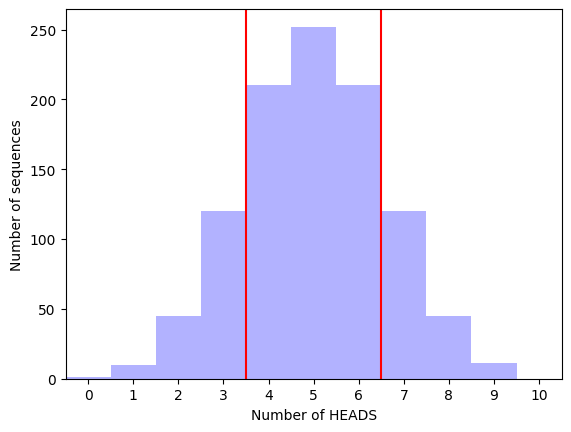

In [45]:
from matplotlib import pyplot as plt

nflips = 10

SampleSpace = product(**{f"f{i}": len(Coin) for i in range(1, nflips + 1)})

### repackage into a JAX array, which we'll use for indexing
sample_space = jnp.array([SampleSpace._tuple(i) for i in range(len(SampleSpace))])

fig, ax = plt.subplots()
_ = ax.hist(sample_space.sum(axis=1).tolist(), color="blue", alpha=0.3)
ax.axvline(4, color="red")
ax.axvline(7, color="red")
ax.set_xticks((jnp.arange(nflips + 1) + 0.5).tolist())
_ = ax.set_ylabel("Number of sequences")
_ = ax.set_xlabel("Number of HEADS")
_ = ax.set_xticklabels(range(nflips + 1))
ax.set_xlim((0, nflips + 1))

(nheads, nsequences) = jnp.unique(sample_space.sum(axis=1), return_counts=True)
for (h, s) in zip(nheads.tolist(), nsequences.tolist()):
    print(f"#HEADS: {h}, #sequences: {s}")

Let’s assign the probability mass for each flip in order to calculate
the probably of each sequence.

In [46]:
### assign the probability mass for each flip
flip_probs_biased = (
    jnp.full_like(
        sample_space, jnp.nan, dtype=float
    )  ### init a new array with nans (for safety)
    .at[jnp.where(sample_space == 1)]  ### for every HEADS
    .set(0.1)  ### assign it prob 0.1
    .at[jnp.where(sample_space == 0)]  ### for every TAILS
    .set(0.9)  ### assign it prob 0.9
    .at[:, :2]  ### for the first two tosses
    .set(0.5)  ### use a fair coin
)

### let's make sure we didn't mess us out indexing in an obvious way
assert not jnp.any(jnp.isnan(flip_probs_biased))

### the probability of a sequence is the product of the individual flips
sequence_probs_biased = flip_probs_biased.prod(axis=1)

### let's make sure the sample space is a simplex
assert jnp.isclose(sequence_probs_biased.sum(), 1.0)

flip_probs_biased

Array([[0.5, 0.5, 0.9, ..., 0.9, 0.9, 0.9],
       [0.5, 0.5, 0.9, ..., 0.9, 0.9, 0.1],
       [0.5, 0.5, 0.9, ..., 0.9, 0.1, 0.9],
       ...,
       [0.5, 0.5, 0.1, ..., 0.1, 0.9, 0.1],
       [0.5, 0.5, 0.1, ..., 0.1, 0.1, 0.9],
       [0.5, 0.5, 0.1, ..., 0.1, 0.1, 0.1]], dtype=float32)

Let’s compare the distributions

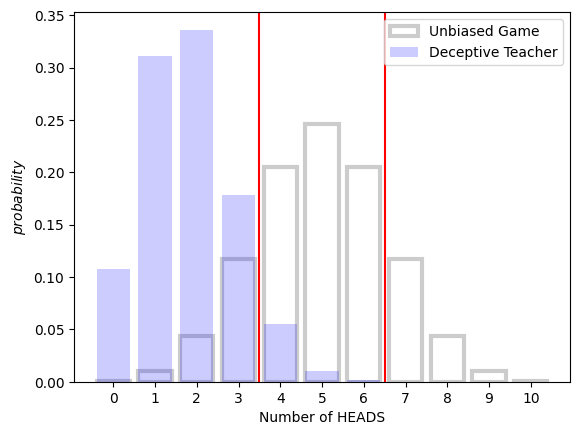

In [47]:
### assign the probability masses for the fair coin
flip_probs_unbiased = jnp.full_like(sample_space, 0.5, dtype=float)

sequence_probs_unbiased = flip_probs_unbiased.prod(axis=1)
assert jnp.isclose(sequence_probs_unbiased.sum(), 1.0)


def calc_probs(sequence_probs):
    probs = []
    for nheads in range(nflips + 1):
        index = jnp.where(sample_space.sum(axis=1) == nheads)
        probs.append(sequence_probs[index].sum().item())
    return probs


fig, ax = plt.subplots()
ax.bar(
    range(nflips + 1),
    calc_probs(sequence_probs_unbiased),
    facecolor="none",
    edgecolor="black",
    linewidth=3.0,
    alpha=0.2,
    label="Unbiased Game",
)
ax.bar(
    range(nflips + 1),
    calc_probs(sequence_probs_biased),
    facecolor="blue",
    alpha=0.2,
    label="Deceptive Teacher",
)
ax.axvline(3.5, color="red")
ax.axvline(6.5, color="red")
_ = ax.set_ylabel("$probability$")
_ = ax.set_xlabel("Number of HEADS")
_ = ax.set_xticks(range(nflips + 1))
ax.legend()

And now we can pass the probability mass we defined to `wpp`.

In [49]:
@jax.jit
def probfn_biased(s):
    return sequence_probs_biased[s]

@jax.jit
def sumseq(s):
    return jnp.sum(jnp.array([*SampleSpace._tuple(s)]))

@memo
def flip_game():
    student: given(s in SampleSpace, wpp=probfn_biased(s))
    return Pr[sumseq(student.s) >= 4 and sumseq(student.s) <= 6]

flip_game()

Array(0.06690601, dtype=float32)

How much did your teacher’s trickery affect your chances?

## Exercise

**A game of dice.** You have 3 die. The first dice has 4 sides, the
second has 6 sides, and third has 8 sides. You roll your three die
twice. The *d4* is fair. The *d6* is loaded such that there’s a 50%
chance that it lands on 6, and a 10% chance that it lands on each other
number. The *d8* is fair for the first roll, then it’s dropped and chips
in such a way that it’s 3x more likely to land on an even number than an
odd number (all evens are equally likely, and all odds are equally
likely).

1.  Write a `@memo` that returns a JAX array with the probabilities of
    every possible combination of the die in this game (*i.e.* across
    all rolls).

2.  Write a `@memo` that returns the probability that the sum of the
    three die on roll 2 is greater than or equal to the sum of the three
    die on roll 1.

### Solution:

This problem is better solved with a respective die class that is based on the coin example. This way we can concisely represent all dies with their respective pmf's.

------------------------------------------------------------------------

In [146]:
class Die4(IntEnum):
    ONE = 1
    TWO = 2
    THREE = 3
    FOUR = 4

Recall that the *d6* is loaded such that there’s a 50%
chance that it lands on 6, and a 10% chance that it lands on each other
number.

In [147]:
class Die6(IntEnum):
    ONE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6

Recall that the *d8* is fair for the first roll, then it’s dropped and chips
in such a way that it’s 3x more likely to land on an even number than an
odd number (all evens are equally likely, and all odds are equally
likely). Here are the probabilities with *d8* alone.

In [148]:
class Die8(IntEnum):
    ONE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8

In [258]:

SampleSpaceRoll1 = product(
    d4=len(Die4), 
    d6=len(Die6), 
    d8=len(Die8)
)


SampleSpace = product( 
    r1 = len(SampleSpaceRoll1),
    r2 = len(SampleSpaceRoll1)
)
    

@jax.jit
def pmf(s):
    r1 = SampleSpace.r1(s)
    r2 = SampleSpace.r2(s)

    p_d4 = 1/4

    idx_d6_r1 = SampleSpaceRoll1.d6(r1)
    idx_d8_r1 = SampleSpaceRoll1.d8(r1)

    idx_d6_r2 = SampleSpaceRoll1.d6(r2)
    idx_d8_r2 = SampleSpaceRoll1.d8(r2)

    prob_d6 = jnp.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])
    p_r1_d6 = prob_d6[idx_d6_r1]
    p_r2_d6 = prob_d6[idx_d6_r2]

    p_r1_d8 = 1/8

    prob_d8_r2 = jnp.array([1/16 if i % 2 == 0 else 3/16 for i in range(8)])
    p_r2_d8 = prob_d8_r2[idx_d8_r2]
    
    
    return p_d4 * p_d4 *  p_r1_d6 * p_r1_d8 * p_r2_d6 * p_r2_d8
    
    

prob_ = pmf(0)
print(f"{prob_:0.10f}")

jnp.array([pmf(i) for i in SampleSpace]).sum()


0.0000048828


Array(1., dtype=float32)

In [265]:
@memo
def g[_c: SampleSpace]():
    observer: given(c in SampleSpace, wpp = pmf(c))
    return Pr[observer.c == _c]

res = g(print_table=True)


+-----------------+-------------------------+
| _c: SampleSpace | g[_c]                   |
+-----------------+-------------------------+
| 0               | 4.882812845607987e-06   |
| 1               | 1.4648438082076609e-05  |
| 2               | 4.882812845607987e-06   |
| 3               | 1.4648438082076609e-05  |
| 4               | 4.882812845607987e-06   |
| 5               | 1.4648438082076609e-05  |
| 6               | 4.882812845607987e-06   |
| 7               | 1.4648438082076609e-05  |
| 8               | 4.882812845607987e-06   |
| 9               | 1.4648438082076609e-05  |
| 10              | 4.882812845607987e-06   |
| 11              | 1.4648438082076609e-05  |
| 12              | 4.882812845607987e-06   |
| 13              | 1.4648438082076609e-05  |
| 14              | 4.882812845607987e-06   |
| 15              | 1.4648438082076609e-05  |
| 16              | 4.882812845607987e-06   |
| 17              | 1.4648438082076609e-05  |
| 18              | 4.882812845607

In [287]:
@memo
def one_greater_than_two():
    observer: given(s in SampleSpace, wpp=pmf(s))
    
    return Pr[sums(observer.s, 1) > sums(observer.s, 2)]


one_greater_than_two(print_table=True)

+-------------------------+
| one_greater_than_two[]  |
+-------------------------+
| 0.4341992437839508      |
+-------------------------+


Array(0.43419924, dtype=float32)

Double checking with writing two seperate functions:

In [296]:
from jax import lax

@jax.jit
def sum1(s):
    r1 = SampleSpace.r1(s)

    idx_d4_r1 = SampleSpaceRoll1.d4(r1)
    idx_d6_r1 = SampleSpaceRoll1.d6(r1)
    idx_d8_r1 = SampleSpaceRoll1.d8(r1)
    return idx_d4_r1 + idx_d6_r1 + idx_d8_r1

@jax.jit
def sum2(s):
    r2 = SampleSpace.r2(s)

    idx_d4_r2 = SampleSpaceRoll1.d4(r2)
    idx_d6_r2 = SampleSpaceRoll1.d6(r2)
    idx_d8_r2 = SampleSpaceRoll1.d8(r2)
    return idx_d4_r2 + idx_d6_r2 + idx_d8_r2

In [297]:
@memo
def one_greater_than_two():
    observer: given(s in SampleSpace, wpp=pmf(s))
    
    return Pr[sum1(observer.s) > sum2(observer.s)]


one_greater_than_two(print_table=True)

+-------------------------+
| one_greater_than_two[]  |
+-------------------------+
| 0.4341992437839508      |
+-------------------------+


Array(0.43419924, dtype=float32)

#### Extension:

The following is an alternate more convoluted approach! We have two observers one for the first one for the second run.

In [312]:
@jax.jit
def pmf1(s):

    p_d4 = 1/4

    idx_d6_r1 = SampleSpaceRoll1.d6(s)
    idx_d8_r1 = SampleSpaceRoll1.d8(s)


    prob_d6 = jnp.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])
    p_r1_d6 = prob_d6[idx_d6_r1]

    p_r1_d8 = 1/8    
    
    return p_d4 * p_r1_d6 * p_r1_d8 
    

@jax.jit
def pmf2(s):

    p_d4 = 1/4

    idx_d6_r2 = SampleSpaceRoll1.d6(s)
    idx_d8_r2 = SampleSpaceRoll1.d8(s)

    prob_d6 = jnp.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])
    p_r2_d6 = prob_d6[idx_d6_r2]

    prob_d8_r2 = jnp.array([1/16 if i % 2 == 0 else 3/16 for i in range(8)])
    p_r2_d8 = prob_d8_r2[idx_d8_r2]
    
    
    return p_d4 * p_r2_d6 * p_r2_d8
    
    


In [313]:
@jax.jit
def sum_conv(s):
    SampleSpaceRoll1.d4(s) + SampleSpaceRoll1.d6(s) + SampleSpaceRoll1.d8(s) 

In [317]:
@memo
def one_greater_than_two_conv():
    observer1: given(s in SampleSpaceRoll1, wpp=pmf1(s))
    observer2: given(s in SampleSpaceRoll1, wpp=pmf2(s))
    
    return Pr[sum_conv(observer1.s) > sum_conv(observer2.s)]

res_conv = one_greater_than_two_conv()

AttributeError: 'NoneType' object has no attribute 'shape'

This method unfortunately failed due to not indexing by the actual indices! I will find an appropriate solution soon.